### 루브릭

|평가문항|	상세기준|
|---|---|
|1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.	|3가지 이상의 모델이 성공적으로 시도됨|
|2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.	|gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함|
|3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.	|네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함|

In [1]:
!ln -sf ~/data/*.txt ~/aiffel/sentiment_classification/data

In [2]:
import pandas
import konlpy
import gensim
import tensorflow as tf

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


### 1) 데이터 준비와 확인

In [3]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab() # 한국어 토크나이저 사용
stopwords = ['의','가','이','은','들','는','좀','잘','걍',
             '과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
#     데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

#     NaN 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any') 
    
    def tokenize_wo_stopwords(sentences):
        result_li = []
        for sentence in sentences:
            temp_X = tokenizer.morphs(sentence) # 토큰화
            temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
            result_li.append(temp_X)
        
        return result_li # result sentences
            
    X_train = tokenize_wo_stopwords(train_data['document'])
    X_test = tokenize_wo_stopwords(test_data['document'])
        
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-3) # 4 -> 3 으로 변경
    print(f'most frequent 6 words:')
    for index, word in enumerate(counter):
        if index == 10: break
        print(f"word #{index}/{len(counter)} is {word}")

#     사전word_to_index 구성
    # '<PAD>'  # 패딩용 단어
    # '<BOS>'  # 문장의 시작지점
    # '<UNK>' # 사전에 없는(Unknown) 단어
    vocab = ['<PAD>', '<BOS>', '<UNK>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
#     텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    # X_train, y_train, X_test, y_test, word_to_index 리턴
    return (X_train, 
            np.array(list(train_data['label'])), 
            X_test, 
            np.array(list(test_data['label'])), 
            word_to_index)
    
    

In [5]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

most frequent 6 words:
word #0/9997 is ('.', 159415)
word #1/9997 is ('영화', 57338)
word #2/9997 is ('다', 54971)
word #3/9997 is ('고', 47196)
word #4/9997 is ('하', 44376)
word #5/9997 is ('을', 29832)
word #6/9997 is ('보', 25603)
word #7/9997 is ('..', 22655)
word #8/9997 is ('게', 22161)
word #9/9997 is (',', 22047)


In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [8]:
i = 13
print(get_decoded_sentence(X_train[i], index_to_word))
print('라벨: ', y_train[i])  # 1번째 리뷰데이터의 라벨

하 고 깔끔 해서 좋 다 . 신문 기사 로 만 보다 보 면 자꾸 <UNK> . 그 사람 었 다는 것 을 .
라벨:  1


### 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [9]:
# 데이터셋 내 문장 길이 분포 확인
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


pad_sequences maxlen :  54
전체 문장의 0.9720946661956905%가 maxlen 설정값 이내에 포함됩니다. 


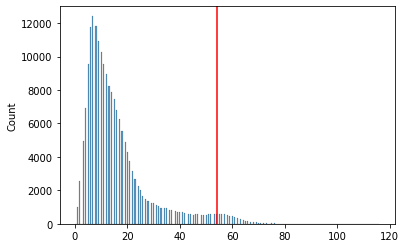

In [10]:
# 적절한 최대 문장 길이 지정
# 최대 길이를 (평균 + 3*표준편차)로 한다면,  기존: 2 -> 3*표준편차
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(num_tokens)
plt.vlines(maxlen, 0, 13000, 'r' )
plt.ylim(0, 13000)
plt.show()

In [11]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 기존 코드에서 'pre' 로 변경함
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 기존 코드에서 'pre' 로 변경함
                                                       maxlen=maxlen)

### 4) 모델 구성 및 validation set 구성

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

- 선정 모델 과 선정 이유:
    - model1: conv1D. 
        - 문장을 token화 하면 1차원의 이미지(?)로 볼 수 있다. conv1d 를 사용한 모델은 지역적인 token 간의 관계성을 학습하도록 inductive bias 가 주어진 모델이다. 지역적인 token 사이에 유의미한 관계가 있기 때문에 Conv1D를 문장 데이터에 사용하는 방법도 가능하다. 단, RNN 계열의 모델보다 성능은 떨어질 것이라 예상하고 비교를 위한 모델로서 선정했다.
    - model2: biLSTM. 
        - 입력 문장을 정방향과 역순으로 처리하도록 2개의 LSTM을 사용하여 학습하는 모델이다. 현재 Input의 정보를 기반으로 과거 기억의 정보를 동시에 이용하여 state를 업데이트 한다. 문장내의 단어에 대해서 처리가 순차적으로 이루어지기 때문에 순서에 대한 정보가 학습되게 된다. 어순에 따라 다른 의미를 가지는 경우가 종종 있고, 서로 멀리 떨어진 단어들 사이에 연관성을 가지고 있는 경우가 있기 때문에 biLSTM 모델을 이용하는것이 적합하다.
    - model3: Transformer. 
        - 입력 문장의 각 token 에 대해서 집중도를 학습하는 방법이다. 순서에 대한 정보는 positional encoding 을 사용하여 모델에 내제화 한다.
        
- 모든 모델들이 학습 가능한 parameter 수가 (~1M)정도로 비슷하도록 모델을 구성했다.

#### Model1: conv1D

In [12]:
# model1 conv1D
def build_conv1d(
    vocab_size = 10000,    # 어휘 사전의 크기입니다(10,000개의 단어)
    word_vector_dim = 100,  # 워드 벡터의 차원 수 
    embeddings_initializer="uniform",
    ):

    # 모델 구성
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, 
                                        word_vector_dim, 
                                        embeddings_initializer=embeddings_initializer,
                                        input_length=maxlen, 
                                        trainable=True,
                                        input_shape=(None,)))
    model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(5))
    model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    return model

In [13]:
model1 = build_conv1d()
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

#### Model2: word2vec + biLSTM

In [14]:
# model2 word2vec + biLSTM
def build_biLSTM(
    vocab_size = 10000,    # 어휘 사전의 크기입니다(10,000개의 단어)
    word_vector_dim = 100,  # 워드 벡터의 차원 수 
    embeddings_initializer="uniform",
    ):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Embedding(
            vocab_size, 
            word_vector_dim, 
            embeddings_initializer=embeddings_initializer,  # 카피한 임베딩을 여기서 활용
            input_length=maxlen, 
            trainable=True,
            input_shape=(None,)
        ))
    model.add(tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(75, return_sequences=True),
        merge_mode="concat",
    ))
    model.add(tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(75, return_sequences=False),
        merge_mode="concat",
    ))
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
    
    return model

In [15]:
model2 = build_biLSTM()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 150)         105600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150)               135600    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                7550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 1,248,801
Trainable params: 1,248,801
Non-trainable params: 0
_________________________________________________________________


In [16]:
# model3 word2vec + Transformer
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config
    
def build_transformer(
    vocab_size = 10000,    # 어휘 사전의 크기입니다(10,000개의 단어)
    word_vector_dim = 100,  # 워드 벡터의 차원 수 
    embeddings_initializer="uniform",
    ):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Embedding(
            vocab_size, 
            word_vector_dim, 
            embeddings_initializer=embeddings_initializer,  # 카피한 임베딩을 여기서 활용
            input_length=maxlen, 
            trainable=True,
            input_shape=(None,)
        ))
    model.add(TransformerEncoder(embed_dim=100, dense_dim=100, num_heads=10))
#     model.add(TransformerEncoder(embed_dim=300, dense_dim=300, num_heads=3)) 
    # 2층을 사용하면 epoch 17 이상에서 train, val loss 가 감소한다. -> 모델 복잡도를 줄여서 재시도
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(75, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
    
    return model

In [17]:
model3 = build_transformer()
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
transformer_encoder (Transfo (None, None, 100)         423700    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 75)                7575      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 76        
Total params: 1,431,351
Trainable params: 1,431,351
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시

In [18]:
import json
def save_model_history(model, history, log_path = '.', run_name = ''):
    model.save(filepath=log_path+'/'+f'{run_name}.ckpt')
    with open(log_path+'/history.json', 'w') as file:
        json.dump(history.history, file)

In [19]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

- Metrics 선정 이유: 모델의 최종 출력 [0,1] 값. 입력 문장에 대한 감정 (2-classes) 분류 작업이었기 때문에 분류에서 많이 사용되는 accuracy 를 골랐다. trainset과 testset 내에서 모두 1:1 정도의 비율로 나뉘어 있어 accuracy 를 이용해도 성능 평가를 적절히 할 수 있다.

In [66]:
print(f'trainset 의 긍정 label 비율: {train_data.label.mean()}.')
print(f'testset 의 긍정 label 비율: {test_data.label.mean()}.')

trainset 의 긍정 label 비율: 0.49828639445079115.
testset 의 긍정 label 비율: 0.5027055616583262.


- Loss 선정 이유: 2인 분류에 적합한 `binary_crossentropy`를 사용했다.

- (+) 학습에 `ModelCheckpoint` callback을 사용하였다.

In [20]:
def train_model(model, log_path='.', epochs=20, verbose=1):
    # 학습의 진행
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
    model_ck_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=log_path+'/best_checkpoint.ckpt',
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
        save_freq="epoch",
        initial_value_threshold=None,
    )


    history = model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(X_val, y_val),
                        callbacks = [model_ck_callback],
                        verbose=1)

    save_model_history(model, history, log_path, 'final_checkpoint')

    return history

In [21]:
history1 = train_model(model1, log_path='logs/model1')

Epoch 1/20
266/266 [==============================] - 5s 7ms/step - loss: 0.5127 - accuracy: 0.7308 - val_loss: 0.4224 - val_accuracy: 0.7920
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3867 - accuracy: 0.8180 - val_loss: 0.4182 - val_accuracy: 0.7900
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3376 - accuracy: 0.8455 - val_loss: 0.4262 - val_accuracy: 0.7919
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2797 - accuracy: 0.8749 - val_loss: 0.4590 - val_accuracy: 0.7928
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2203 - accuracy: 0.9039 - val_loss: 0.5159 - val_accuracy: 0.7844
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1729 - accuracy: 0.9236 - val_loss: 0.5973 - val_accuracy: 0.7855
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1407 - accuracy: 0.9366 - val_loss: 0.6830 - val_accuracy: 0.7765
Epoch 

In [22]:
history2 = train_model(model2, log_path='logs/model2')

Epoch 1/20
266/266 [==============================] - 15s 37ms/step - loss: 0.3957 - accuracy: 0.8193 - val_loss: 0.3379 - val_accuracy: 0.8529
Epoch 2/20
266/266 [==============================] - 9s 33ms/step - loss: 0.3156 - accuracy: 0.8645 - val_loss: 0.3296 - val_accuracy: 0.8568
Epoch 3/20
266/266 [==============================] - 9s 33ms/step - loss: 0.2818 - accuracy: 0.8803 - val_loss: 0.3249 - val_accuracy: 0.8611
Epoch 4/20
266/266 [==============================] - 9s 33ms/step - loss: 0.2530 - accuracy: 0.8933 - val_loss: 0.3372 - val_accuracy: 0.8566
Epoch 5/20
266/266 [==============================] - 9s 34ms/step - loss: 0.2268 - accuracy: 0.9058 - val_loss: 0.3631 - val_accuracy: 0.8602
Epoch 6/20
266/266 [==============================] - 9s 34ms/step - loss: 0.2032 - accuracy: 0.9173 - val_loss: 0.3738 - val_accuracy: 0.8575
Epoch 7/20
266/266 [==============================] - 9s 34ms/step - loss: 0.1826 - accuracy: 0.9259 - val_loss: 0.3948 - val_accuracy: 0.857

INFO:tensorflow:Assets written to: logs/model2/final_checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: logs/model2/final_checkpoint.ckpt/assets


In [23]:
history3 = train_model(model3, log_path='logs/model3')

Epoch 1/20
266/266 [==============================] - 21s 74ms/step - loss: 0.4057 - accuracy: 0.8131 - val_loss: 0.3427 - val_accuracy: 0.8466
Epoch 2/20
266/266 [==============================] - 20s 74ms/step - loss: 0.3027 - accuracy: 0.8711 - val_loss: 0.3517 - val_accuracy: 0.8474
Epoch 3/20
266/266 [==============================] - 19s 73ms/step - loss: 0.2631 - accuracy: 0.8912 - val_loss: 0.3525 - val_accuracy: 0.8474
Epoch 4/20
266/266 [==============================] - 19s 73ms/step - loss: 0.2301 - accuracy: 0.9070 - val_loss: 0.3676 - val_accuracy: 0.8464
Epoch 5/20
266/266 [==============================] - 19s 73ms/step - loss: 0.1952 - accuracy: 0.9230 - val_loss: 0.3966 - val_accuracy: 0.8383
Epoch 6/20
266/266 [==============================] - 19s 73ms/step - loss: 0.1625 - accuracy: 0.9368 - val_loss: 0.4291 - val_accuracy: 0.8428
Epoch 7/20
266/266 [==============================] - 20s 73ms/step - loss: 0.1340 - accuracy: 0.9488 - val_loss: 0.4747 - val_accuracy:

INFO:tensorflow:Assets written to: logs/model3/final_checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: logs/model3/final_checkpoint.ckpt/assets


### 6) Loss, Accuracy 그래프 시각화

In [24]:
import matplotlib.pyplot as plt

def plot_history(history):

    history_dict = history.history if isinstance(history, tf.keras.callbacks.History) else history

    try:
        acc = history_dict['accuracy']
        val_acc = history_dict['val_accuracy']
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']
    except KeyError as e:
        print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
        raise e
    
    epochs = range(1, len(acc) + 1)
    
    ## Loss 그래프 시각화
    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
    ## Accuracy 그래프 시각화
    plt.clf()   # 그림을 초기화합니다

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

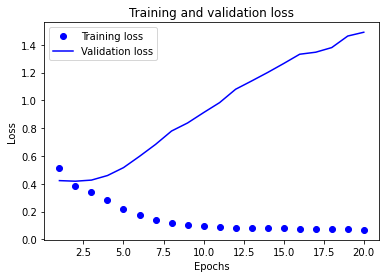

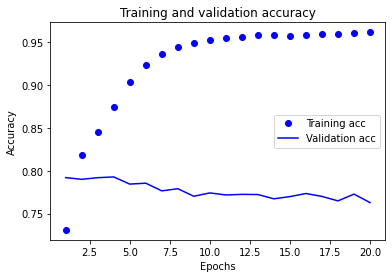

In [25]:
plot_history(history1)

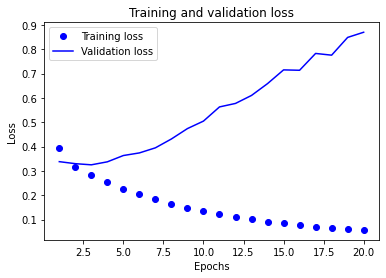

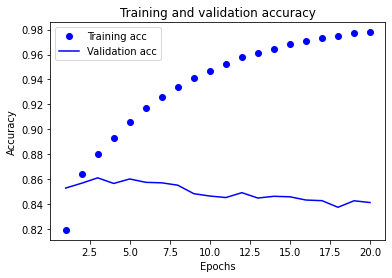

In [26]:
plot_history(history2)

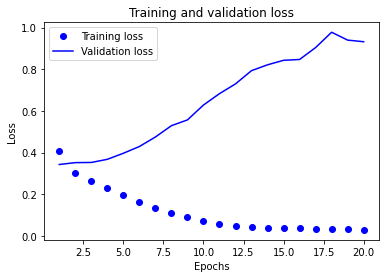

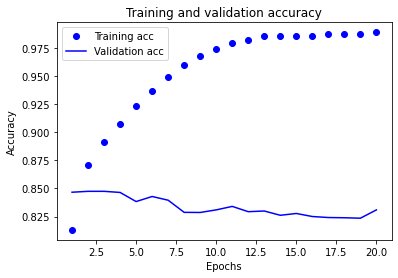

In [27]:
plot_history(history3)

#### 성능 평가

In [28]:
# load best model 1
model1.load_weights('logs/model1/best_checkpoint.ckpt')
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# load best model 2
model2.load_weights('logs/model2/best_checkpoint.ckpt')
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# load best model 3
model3.load_weights('logs/model3/best_checkpoint.ckpt')
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluation in testset
print(model1.evaluate(X_test,  y_test, verbose=2))
print(model2.evaluate(X_test,  y_test, verbose=2))
print(model3.evaluate(X_test,  y_test, verbose=2))


1537/1537 - 3s - loss: 0.4198 - accuracy: 0.7969
[0.4197532832622528, 0.7968752980232239]
1537/1537 - 10s - loss: 0.3374 - accuracy: 0.8545
[0.3373592495918274, 0.8544663190841675]
1537/1537 - 6s - loss: 0.3494 - accuracy: 0.8458
[0.3494020402431488, 0.8458002209663391]


### 7) 학습된 Embedding 레이어 분석
- gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석

In [29]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [30]:
def save_word2vec(model, 
                  save_dir='.',
                  filename='word2vec.txt',
                  vocab_size=10000):
    embedding_layer = model.layers[0]
    
    vocab_size = embedding_layer.input_dim
    word_vector_dim = embedding_layer.output_dim
    weights = embedding_layer.get_weights()[0]
    
    word2vec_file_path = save_dir + '/' + filename
    
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-3, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
    vectors = model.get_weights()[0]
    for i in range(3,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()
    return word2vec_file_path

In [31]:
!ls ~/data
!ln -sf ~/data/word2vec_ko.model* ~/aiffel/sentiment_classification/data
# !ls ~/aiffel/sentiment_classification/data

GoogleNews-vectors-negative300.bin.gz  word2vec_ko.model
ratings_test.txt		       word2vec_ko.model.trainables.syn1neg.npy
ratings_train.txt		       word2vec_ko.model.wv.vectors.npy


#### find similar word with model1

In [32]:
import os
word2vec_file_path = save_word2vec( model1, 
              save_dir = os.getenv('HOME')+'/aiffel/sentiment_classification/logs/model1',
              filename = 'word2vec.txt'
)

In [33]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

result = word_vectors.similar_by_word("사랑")
for i in range(6):
    most_similar_key, similarity = result[i]  # look at the first match
    print(f"{i}.  {most_similar_key}: {similarity:.4f}")

0.  울컥: 0.7976
1.  탄탄: 0.7864
2.  따스: 0.7842
3.  아련: 0.7814
4.  신들린: 0.7808
5.  진진: 0.7784


#### find similar word with model2

In [34]:
word2vec_file_path = save_word2vec( model2, 
              save_dir = os.getenv('HOME')+'/aiffel/sentiment_classification/logs/model2',
              filename = 'word2vec.txt'
)

In [35]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
result = word_vectors.similar_by_word("사랑")
for i in range(6):
    most_similar_key, similarity = result[i]  # look at the first match
    print(f"{i}.  {most_similar_key}: {similarity:.4f}")

0.  훌쩍: 0.8255
1.  9: 0.8239
2.  명화: 0.8220
3.  올려야: 0.8147
4.  정점: 0.8035
5.  놓치: 0.8031


#### find similar word with model3

In [36]:
word2vec_file_path = save_word2vec( model3, 
              save_dir = os.getenv('HOME')+'/aiffel/sentiment_classification/logs/model3',
              filename = 'word2vec.txt'
)

In [37]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
result = word_vectors.similar_by_word("사랑")
for i in range(6):
    most_similar_key, similarity = result[i]  # look at the first match
    print(f"{i}.  {most_similar_key}: {similarity:.4f}")

0.  인간: 0.4942
1.  소장: 0.4111
2.  리들리스콧: 0.4057
3.  두려움: 0.3987
4.  경쾌: 0.3942
5.  다물: 0.3867


#### find similar word with Kor Word2Vec

In [38]:
# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = '/aiffel/aiffel/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
# word_vectors = word_vectors.wv.vectors

In [39]:
result = word_vectors.wv.similar_by_word("사랑")
for i in range(6):
    most_similar_key, similarity = result[i]  # look at the first match
    print(f"{i}.  {most_similar_key}: {similarity:.4f}")

0.  이별: 0.7626
1.  행복: 0.7550
2.  슬픔: 0.7382
3.  유혹: 0.7238
4.  그리움: 0.7167
5.  추억: 0.7144


### [루브릭] 그나마 성능이 높은 biLSTM 모델의 embedding layer 가 의미의 유사도를 잘 표현하고 있다. Word2Vec_ko 는 유사어 찾기에서 인상적인 결과를 보였다.


### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

- 한국어 Word2Vec은 `/data` 폴더 안에 있는 `word2vec_ko.model`을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 `load_word2vec_format()` 형태가 아닌 `load()` 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 `.wv`를 붙여서 활용합니다. 

In [40]:
wv = word_vectors.wv
for index, word in enumerate(wv.index_to_key):
    if index == 10: break
    print(f"word #{index}/{len(wv.index_to_key)} is {word}")


word #0/302960 is .
word #1/302960 is 의
word #2/302960 is 다
word #3/302960 is 이
word #4/302960 is 는
word #5/302960 is /
word #6/302960 is ="
word #7/302960 is ,
word #8/302960 is 에
word #9/302960 is 을


In [41]:
joint = sum(w in wv.index_to_key for w in index_to_word.values())
print(f'{joint} words are overlapped among ours: 10000. vocab size of word2vec_ko: {len(wv.key_to_index)}')

9454

In [42]:
[w for w in wv.index_to_key if '<' in w]

['<', '</']

In [43]:
[w for w in wv.index_to_key if '>' in w]

['>',
 '">',
 '~">',
 '-">',
 '+">',
 '°">',
 '!">',
 '%">',
 '..">',
 ';">',
 '\'">',
 ')">',
 '++">',
 '²">',
 '〜">',
 '!!">',
 '♪">',
 '?">',
 '㎡">',
 '〉">',
 '$">',
 '*">',
 '］">',
 '+)">',
 '½">',
 '～">',
 '℃">',
 '☆">',
 '＃">',
 '∞">',
 '`">',
 '㈜">',
 '-)">',
 '♂">',
 '。">']

In [44]:
wv.vector_size

100

In [45]:
wv.__dir__()

['vector_size',
 '__numpys',
 '__scipys',
 '__ignoreds',
 '__recursive_saveloads',
 'vectors',
 'index_to_key',
 'norms',
 'expandos',
 'key_to_index',
 'vectors_lockf',
 '__module__',
 '__init__',
 '_load_specials',
 '_upconvert_old_vocab',
 'allocate_vecattrs',
 'set_vecattr',
 'get_vecattr',
 'resize_vectors',
 '__len__',
 '__getitem__',
 'get_index',
 'get_vector',
 'word_vec',
 'add_vector',
 'add_vectors',
 '__setitem__',
 'has_index_for',
 '__contains__',
 'most_similar_to_given',
 'closer_than',
 'words_closer_than',
 'rank',
 'vectors_norm',
 'get_normed_vectors',
 'fill_norms',
 'index2entity',
 'index2word',
 'vocab',
 'sort_by_descending_frequency',
 'save',
 'most_similar',
 'similar_by_word',
 'similar_by_key',
 'similar_by_vector',
 'wmdistance',
 'most_similar_cosmul',
 'rank_by_centrality',
 'doesnt_match',
 'cosine_similarities',
 'distances',
 'distance',
 'similarity',
 'n_similarity',
 '_log_evaluate_word_analogies',
 'evaluate_word_analogies',
 'log_accuracy',
 'l

In [46]:
[w for w in wv.index_to_key if '' in w]

['.',
 '의',
 '다',
 '이',
 '는',
 '/',
 '="',
 ',',
 '에',
 '을',
 '"',
 '하',
 'doc',
 '은',
 ')',
 '(',
 '년',
 '를',
 '고',
 '에서',
 '있',
 ':',
 '으로',
 '가',
 '?',
 '=',
 'https',
 'org',
 'id',
 'title',
 'wiki',
 'wikipedia',
 'ko',
 'url',
 '<',
 'curid',
 '</',
 '>',
 '">',
 '되',
 '로',
 '한',
 '었',
 '과',
 '들',
 '월',
 '했',
 '와',
 '적',
 '일',
 '도',
 '였',
 '인',
 '그',
 '어',
 '기',
 '것',
 '1',
 '2',
 '지',
 '게',
 '여',
 '한다',
 '수',
 '된',
 '-',
 '등',
 '3',
 '며',
 "'",
 '던',
 '할',
 '4',
 '제',
 '해',
 '5',
 '않',
 '만',
 '까지',
 '았',
 '자',
 '명',
 '으며',
 '중',
 '에게',
 '《',
 '대',
 '받',
 '6',
 '~',
 '지만',
 '된다',
 '주',
 '아',
 '같',
 '성',
 '부터',
 '개',
 '사용',
 '·',
 '때',
 '10',
 '7',
 '8',
 '면',
 '미국',
 '후',
 '이후',
 '라고',
 '번',
 '라는',
 '나',
 '세',
 '면서',
 '없',
 '시',
 '전',
 '두',
 '는데',
 '》',
 '대한민국',
 '및',
 '말',
 '다음',
 '9',
 '일본',
 '지역',
 '대한',
 '다른',
 '군',
 '12',
 '다고',
 '역',
 '라',
 ';',
 '위',
 '11',
 '화',
 '때문',
 '시작',
 '&',
 '사람',
 '위해',
 '팀',
 '함께',
 '또한',
 '많',
 '선수',
 '더',
 '영화',
 '국가',
 '현재',
 '세계',
 '자신',
 '

In [53]:
print('Using pre-trained word embedding...')

def gen_emb_mat(index_to_word, word2vec):
    vocab_size = len(index_to_word)    # 어휘 사전의 크기입니다(10,000개의 단어)
    word_vector_dim = word2vec.vector_size # 워드 벡터의 차원수
    print(f'vocab_size:{vocab_size},  word_vector_dim:{word_vector_dim}')

    embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

    # embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
    for i in range(3,vocab_size):
        if index_to_word[i] in word2vec:
            embedding_matrix[i] = word2vec[index_to_word[i]]

    return embedding_matrix

Using pre-trained word embedding...


In [54]:
embedding_matrix = gen_emb_mat(index_to_word, wv)

vocab_size:10000,  word_vector_dim:100


#### model4: word2vec_ko + biLSTM

In [55]:
from tensorflow.keras.initializers import Constant
model4 = build_biLSTM(embeddings_initializer=Constant(embedding_matrix))
model4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 150)         105600    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 150)               135600    
_________________________________________________________________
dense_8 (Dense)              (None, 50)                7550      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 1,248,801
Trainable params: 1,248,801
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
266/266 [==============================] - 15s 38ms/step - loss: 0.4519 - accuracy: 0.7831 - val_loss: 0.3666 - val_accuracy: 0.8330
Epoch 2/20
266/266 [==============================] - 9s 35ms/step - loss: 0.3346 - accuracy: 0.8531 - val_loss: 0.3281 - val_accuracy: 0.8557
Epoch 3/20
266/266 [==============================] - 9s 34ms/step - loss: 0.2900 - accuracy: 0.8754 - val_loss: 0.3091 - val_accuracy: 0.8631
Epoch 4/20
266/266 [==============================] - 9s 34ms/step - loss: 0.2613 - accuracy: 0.8899 - val_loss: 0.3128 - val_accuracy: 0.8668
Epoch 5/20
266/266 [==============================] - 9s 34ms/step - loss: 0.2378 - accuracy: 0.9004 - val_loss: 0.3161 - val_accuracy: 0.8680
Epoch 6/20
266/266 [==============================] - 9s 33ms/step - loss: 0.2146 - accuracy: 0.9118 - val_loss: 0.3402 - val_accuracy: 0.8654
Epoch 7/20
266/266 [==============================] - 9s 33ms/step - loss: 0.1933 - accuracy: 0.9215 - val_loss: 0.3367 - val_accuracy: 0.863

INFO:tensorflow:Assets written to: logs/model4/final_checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: logs/model4/final_checkpoint.ckpt/assets


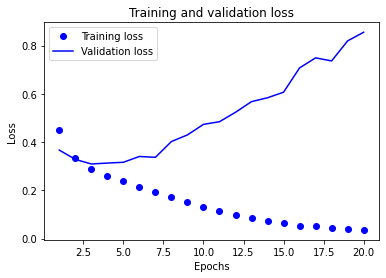

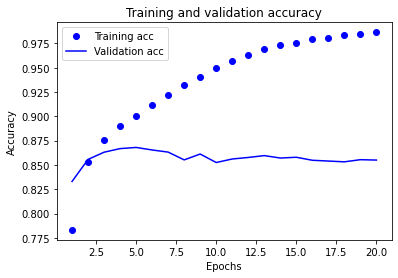

In [56]:
history4 = train_model(model4, log_path='logs/model4')
plot_history(history4)

In [67]:
# load best model 3
model4.load_weights('logs/model4/best_checkpoint.ckpt')
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Evaluation in testset
print(model4.evaluate(X_test,  y_test, verbose=2))


1537/1537 - 11s - loss: 0.3178 - accuracy: 0.8608
[0.3177874684333801, 0.860752284526825]


In [68]:
print(model2.evaluate(X_test,  y_test, verbose=2))

1537/1537 - 8s - loss: 0.3374 - accuracy: 0.8545
[0.3373592495918274, 0.8544663190841675]


### [루브릭] **기존 성능 accuracy: 0.8545 에서 accuracy: 0.8608 로 개선되었다!!!**

#### model5: word2vec_ko + transformer

In [58]:
model5 = build_transformer(embeddings_initializer=Constant(embedding_matrix))
model5.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
transformer_encoder_1 (Trans (None, None, 100)         423700    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 75)                7575      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 76        
Total params: 1,431,351
Trainable params: 1,431,351
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
266/266 [==============================] - 21s 75ms/step - loss: 0.4738 - accuracy: 0.7653 - val_loss: 0.3983 - val_accuracy: 0.8209
Epoch 2/20
266/266 [==============================] - 20s 75ms/step - loss: 0.3613 - accuracy: 0.8391 - val_loss: 0.3505 - val_accuracy: 0.8463
Epoch 3/20
266/266 [==============================] - 19s 73ms/step - loss: 0.3310 - accuracy: 0.8556 - val_loss: 0.3490 - val_accuracy: 0.8433
Epoch 4/20
266/266 [==============================] - 19s 73ms/step - loss: 0.3114 - accuracy: 0.8660 - val_loss: 0.3466 - val_accuracy: 0.8494
Epoch 5/20
266/266 [==============================] - 19s 73ms/step - loss: 0.2928 - accuracy: 0.8751 - val_loss: 0.3408 - val_accuracy: 0.8504
Epoch 6/20
266/266 [==============================] - 20s 74ms/step - loss: 0.2778 - accuracy: 0.8822 - val_loss: 0.3469 - val_accuracy: 0.8472
Epoch 7/20
266/266 [==============================] - 19s 73ms/step - loss: 0.2639 - accuracy: 0.8889 - val_loss: 0.3529 - val_accuracy:

INFO:tensorflow:Assets written to: logs/model5/final_checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: logs/model5/final_checkpoint.ckpt/assets


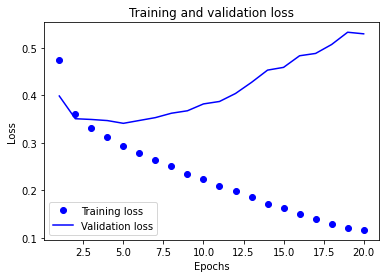

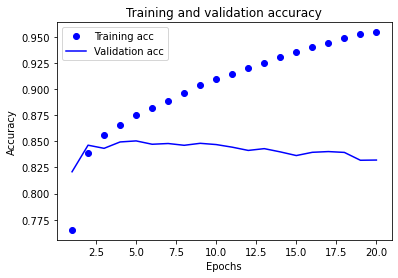

In [59]:
history5 = train_model(model5, log_path='logs/model5')
plot_history(history5)

In [60]:
# load best model 3
model5.load_weights('logs/model5/best_checkpoint.ckpt')
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Evaluation in testset
print(model5.evaluate(X_test,  y_test, verbose=2))

1537/1537 - 6s - loss: 0.3513 - accuracy: 0.8470
[0.3513440787792206, 0.847041130065918]


In [69]:
print(model3.evaluate(X_test,  y_test, verbose=2))

1537/1537 - 5s - loss: 0.3494 - accuracy: 0.8458
[0.3494020402431488, 0.8458002209663391]


### [루브릭] **기존 성능 accuracy: 0.8458 에서 accuracy: 0.8470 로 개선되었다!!!**

### [루브릭] **model4: word2vec + biLSTM 의 성능은 accuracy: 86.08 % 로 85% 보다 높다!!!**

## 회고


### 배운점
- 의미가 없는 단어가 vocabulary 에 있는게 도움이 되지 않는다.
- Transformer 모델자체가 복잡도가 높은 모델이었다. 학습자체가 잘 되지 않았다.

### 아쉬운점
- keras tuner 를 사용하여 다양한 Hyper parameter tuning 을 하여 성능을 더 올릴 수 있다면 더 좋았을것 같다.
    - layers, hidden dim, dropout, word vector dimension etc.

### 느낀점
- Transformer 대비 , biLSTM 과 conv 모델은 굉장히 빠르게 (< 5 epoch) 학습이 된다.

### 어려웠던점
- model 학습 중간에 callback 을 안넣었어서 20 Epoch 의 최근 모델로 평가한 성능이 좋지 않았다.
    - 학습에 `ModelCheckpoint` callback을 사용하고, best model 을 다시 불러와 성능을 평가했다.
